In [ ]:
"""
To cleanly write the limb split method 
once you have the graph where you want to split it

"""

In [1]:
from os import sys
sys.path.append("/meshAfterParty/")

In [2]:
from importlib import reload

import neuron_utils as nru

import neuron

import neuron_visualizations as nviz

import time

import datajoint_utils as du
du = reload(du)

INFO - 2020-11-27 09:05:58,102 - settings - Setting database.host to at-database.ad.bcm.edu
INFO - 2020-11-27 09:05:58,104 - settings - Setting database.user to celiib
INFO - 2020-11-27 09:05:58,105 - settings - Setting database.password to newceliipass
INFO - 2020-11-27 09:05:58,109 - settings - Setting database.host to at-database.ad.bcm.edu
INFO - 2020-11-27 09:05:58,110 - settings - Setting database.user to celiib
INFO - 2020-11-27 09:05:58,111 - settings - Setting database.password to newceliipass


In [3]:
import neuron_visualizations as nviz
curr_seg_id = 864691134884742394
minnie,schema = du.configure_minnie_vm()

INFO - 2020-11-27 09:06:01,126 - settings - Setting stores to {'minnie65': {'protocol': 'file', 'location': '/mnt/dj-stor01/platinum/minnie65', 'stage': '/mnt/dj-stor01/platinum/minnie65'}, 'meshes': {'protocol': 'file', 'location': '/mnt/dj-stor01/platinum/minnie65/02/meshes', 'stage': '/mnt/dj-stor01/platinum/minnie65/02/meshes'}, 'decimated_meshes': {'protocol': 'file', 'location': '/mnt/dj-stor01/platinum/minnie65/02/decimated_meshes', 'stage': '/mnt/dj-stor01/platinum/minnie65/02/decimated_meshes'}, 'skeletons': {'protocol': 'file', 'location': '/mnt/dj-stor01/platinum/minnie65/02/skeletons'}}
INFO - 2020-11-27 09:06:01,127 - settings - Setting enable_python_native_blobs to True
INFO - 2020-11-27 09:06:01,140 - connection - Connected celiib@at-database.ad.bcm.edu:3306
INFO - 2020-11-27 09:06:01,327 - settings - Setting enable_python_native_blobs to True


Connecting celiib@at-database.ad.bcm.edu:3306


In [5]:
neuron_obj = (minnie.Decomposition() & dict(segment_id=curr_seg_id)).fetch1("decomposition")
ret_col = nviz.visualize_neuron(neuron_obj,
                     visualize_type=["mesh","skeleton"],
                     limb_branch_dict=dict(L0="all"),
                     return_color_dict=True)


 Working on visualization type: mesh

 Working on visualization type: skeleton
Working on  new stand alone scatter points


# Getting to the seperate graphs

In [12]:
"""
Find path to cut:
1) Get the concept network
2) Get all of the starting nodes for somas
3) Get the shortest path between each combination of starting nodes

"""
def get_best_cut_edge(curr_limb_graph,cut_path):
    return [18,17]


import itertools
import networkx as nx
import copy

verbose = True

curr_limb_idx = 0
curr_limb = neuron_obj[curr_limb_idx]
curr_limb_graph = copy.deepcopy(curr_limb.concept_network)

#2) Get all of the starting nodes for somas
all_starting_nodes = [k["starting_node"] for k in curr_limb.all_concept_network_data]

starting_node_combinations = list(itertools.combinations(all_starting_nodes,2))

for st_n_1,st_n_2 in starting_node_combinations:
    # need to keep cutting until no path for them
    if verbose:
        print(f"---- working on disconnecting {st_n_1} and {st_n_2}")
        
    counter = 0
    while True:
        if verbose:
            print(f" Cut iteration {counter}")
        try:
            soma_to_soma_path = nx.shortest_path(curr_limb_graph,st_n_1,st_n_2)
        except:
            print("No valid path so just skipping ")
            break

        if verbose:
            print(f"Shortest path = {soma_to_soma_path}")

        # say we found the cut node to make
        cut_edge = get_best_cut_edge(curr_limb_graph,soma_to_soma_path)
        curr_limb_graph.remove_edge(*cut_edge)
        
        counter += 1


seperated_graphs = list(nx.connected_components(curr_limb_graph))
print(f"Total number of graphs at the end of the split = {len(seperated_graphs)}")



---- working on disconnecting 2 and 62
 Cut iteration 0
Shortest path = [2, 1, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 62]
in remove edge
 Cut iteration 1
No valid path so just skipping 
Total number of graphs at the end of the split = 2


# Seeing the Degrees of the Soma to Soma Path

In [35]:
xu.get_node_degree(neuron_obj[0].concept_network,node_name=soma_to_soma_path)

[2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1]

# Function which will split neuron object

In [16]:
import numpy as np
import preprocessing_vp2 as pre
import networkx_utils as xu
import trimesh_utils as tu

In [27]:
import error_detection as ed
ed = reload(ed)

In [28]:
revised_neuron = ed.split_neuron_limb(neuron_obj,
                     seperated_graphs,
                     curr_limb_idx,
                     verbose = False)



---------Working on soma_idx = 0, soma_group_idx 0, endpt = [877209. 741231. 615803.]---------
Starting_edge inside branches_to_conept = [[875212. 742061. 616893.]
 [877209. 741231. 615803.]]
At the start, starting_node (in terms of the skeleton, that shouldn't match the starting edge) = [19]
printing out current edge:
[[877209. 741231. 615803.]
 [875212. 742061. 616893.]]
edge_endpoints_to_process was empty so exiting loop after 38 iterations
starting_node in concept map (that should match the starting edge) = 2
Total time for branches to concept conversion = 1.3381364345550537

Done generating concept network 


recovered_touching_piece = [2]
concept_network_dict = {0: [<networkx_utils.GraphOrderedEdges object at 0x7f09937dbb70>]}
checking and resolving cycles
No cycles to fix


---------Working on soma_idx = 0, soma_group_idx 0, endpt = [883192.09948913 743523.79014019 611188.81171996]---------
Starting_edge inside branches_to_conept = [[883192.09948913 743523.79014019 611188.8117

In [29]:
nviz.visualize_neuron(revised_neuron,
                     visualize_type=["mesh","skeleton"],
                      limb_branch_dict="all",
                     mesh_resolution="limb",
                     skeleton_resolution="limb")


 Working on visualization type: mesh

 Working on visualization type: skeleton
Working on  new stand alone scatter points


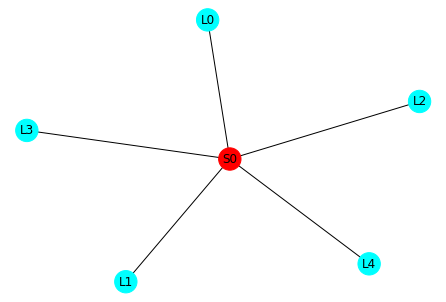

In [23]:
nviz.plot_soma_limb_concept_network(neuron_obj)

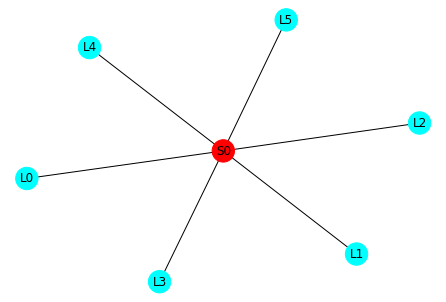

In [24]:
nviz.plot_soma_limb_concept_network(revised_neuron)